# Example: Computing the Covariance of Logarithmic Returns
Suppose we have a portfolio $\mathcal{P}$ with $M$ risky assets, i.e., stocks and ETFs.
The covariance of the return of assets $i$ and $j$, denoted as $\text{cov}\left(r_{i},r_{j}\right)$, is the $\mathbf{\Sigma}\in\mathbb{R}^{M\times{M}}$ matrix 
which quantifies the relationship of the returns of assets $i$ and $j$ in the portfolio $\mathcal{P}$. An element  $\Sigma_{ij}\in\mathbf{\Sigma}$ is given by: 
$$
\begin{equation*}
    \Sigma_{ij} = \text{cov}\left(r_{i},r_{j}\right) = \sigma_{i}\,\sigma_{j}\,\rho_{ij}\qquad\text{for}\quad{i,j \in \mathcal{P}}
\end{equation*}
$$
where $\sigma_{\star}$ denote the standard deviation of the return of asset $\star$, and $\rho_{ij}$ 
denotes the correlation between assets $i$ and $j$ in the portfolio $\mathcal{P}$. The correlation is given by:
$$
\begin{equation*}
\rho_{ij} = \frac{\mathbb{E}(r_{i}-\mu_{i})\cdot\mathbb{E}(r_{j} - \mu_{j})}{\sigma_{i}\cdot\sigma_{j}}\qquad\text{for}\quad{i,j \in \mathcal{P}}
\end{equation*}
$$
The diagonal elements of the covariance matrix $\Sigma_{ii}\in\mathbf{\Sigma}$ are the variances of the returns of asset $i$, while the off-diagonal elements $\Sigma_{ij}\in\mathbf{\Sigma}$ for $i\neq{j}$ measure the relationship between returns of asset $i$ and $j$ in the portfolio $\mathcal{P}$.

## Learning objective
This example will familiarize students with estimating the covariance matrix $\Sigma$ from data and looking at the relationship between firms in our return dataset by sampling a multivariate normal distribution.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material.

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

### Constants

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value):

In [14]:
Δt = (1.0/252);
number_of_samples = 10000;

## Task 1: Compute the return and covariance matrix
In this task, we'll compute the return and covariance for all of the assets in our dataset.

* Compute the expected log return by passing the `dataset` and a list of firms we are interested in (held in the $N\times{1}$ `list_of_all_firms` array) to [the `log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#Computing-returns). 
* The result is stored in the `growth_rate_matrix` variable, a $T-1\times{N}$ array of log return values.  Each row of `growth_rate_matrix` corresponds to a time-value, while each column corresponds to a firm: 

In [16]:
growth_rate_matrix = log_growth_matrix(dataset, list_of_all_firms, Δt = Δt);

Next, we estimate the annualized `covariance_matrix` from the `growth_rate_matrix` using the `cov(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the `covariance_matrix::Array{Float64,2}` in the `Σ` variable:

In [18]:
R = growth_rate_matrix*Δt; # return
Σ = 252*cov(R); # annualized covariance matrix

In [19]:
Σ

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

## Task 2: Visualize the relationship between firms
In this task, we pick any two firms from the `dataset` by finding their `ticker` symbol in the `list_of_all_firms` and visualize the covariance between each firm.
* The `Σ` matrix is in the same order as the `list_of_all_firms` array. Thus, to find the index of a `ticker,` we need to search the `list_of_all_firms::Array{String,1}` array for the firm's index.

In [65]:
ticker_1 = "SPY"; # select a ticker
ticker_2 = "QQQ"; # select a ticker
i = findfirst(x->x == ticker_1, list_of_all_firms); 
j = findfirst(x->x == ticker_2, list_of_all_firms);

Next, estimate the annualized mean growth (return) for a year for firms `i` and `j` and save this in the `μ̂::Array{Float64,1}` vector. The first element of `μ̂` will correspond to the growth rate of `ticker_1`, while the second is the growth of `ticker_2`.

In [67]:
μ̂ = (1/Δt)*[mean(R[:,i]), mean(R[:,j])] # annualized growth rate

2-element Vector{Float64}:
 0.09461549125844322
 0.07141442137137505

Then, construct the covariance matrix for firms `i` and `j` and save it in the `Σ̂::Array{Float64,2}` variable:

In [69]:
Σ̂ = [
    Σ[i,i] Σ[i,j] ;
    Σ[j,i] Σ[j,j] ;
]

2×2 Matrix{Float64}:
 0.0252318   0.00207476
 0.00207476  0.0170404

#### Visualize
For visualization purposes, assume the returns were drawn from a [Multivariate Normal Distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) with mean $\hat{\mu}$ and covariance $\hat{\Sigma}$. We use the `MvNormal(...)` function exported from the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl.git) package to generate samples from the distribution. We store these samples in the `X::Array{Float64,2}` variable.

In [71]:
X = MvNormal(μ̂,Σ̂) |> d-> rand(d, number_of_samples);

`Unhide` the code block below to see how we visualized the distribution of growth rates (return) for the two tickers we selected.

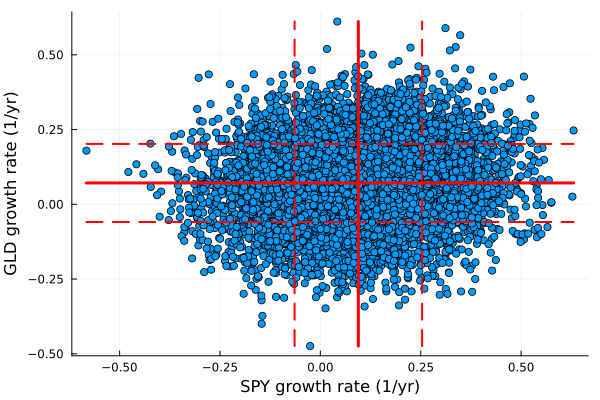

In [73]:
let
    MU_VERT_LINE_1 = zeros(number_of_samples,2);
    MU_VERT_LINE_2 = zeros(number_of_samples,2);
    MU_VERT_LINE_1[:,1] .= μ̂[1]*ones(number_of_samples);
    MU_VERT_LINE_1[:,2] .= range(minimum(X[2,:]),stop=maximum(X[2,:]),length = number_of_samples);
    MU_VERT_LINE_2[:,2] .= μ̂[2]*ones(number_of_samples);
    MU_VERT_LINE_2[:,1] .= range(minimum(X[1,:]),stop=maximum(X[1,:]),length = number_of_samples);
    scatter(X[1,:], X[2,:], xlabel="$(ticker_1) growth rate (1/yr)", ylabel="$(ticker_2) growth rate (1/yr)", label="")
    
    # plot the mean lines -
    plot!(MU_VERT_LINE_1[:,1], MU_VERT_LINE_1[:,2],c=:red,lw=3, label="")
    plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2],c=:red,lw=3, label="")
    
    # plot the std lines -
    plot!(MU_VERT_LINE_1[:,1].+ sqrt(Σ[i,i]), MU_VERT_LINE_1[:,2],c=:red,lw=2, ls=:dash, label="")
    plot!(MU_VERT_LINE_1[:,1].- sqrt(Σ[i,i]), MU_VERT_LINE_1[:,2],c=:red,lw=2, ls=:dash, label="")
    plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2] .+ sqrt(Σ[j,j]),c=:red,lw=2, ls=:dash, label="")
    plot!(MU_VERT_LINE_2[:,1], MU_VERT_LINE_2[:,2] .- sqrt(Σ[j,j]),c=:red,lw=2, ls=:dash, label="")
end

### Compute the correlation
Finally, we estimate the correlation $\rho$ between firm `i` and `j` using the [`cor(...)` function which is exported by the Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the correlation in the `ρ` variable:

In [75]:
ρ = cor(X[1,:],X[2,:])
println("The correlation between firm 1 = $(ticker_1) and 2 = $(ticker_2) equals: ρ = $(ρ)")

The correlation between firm 1 = SPY and 2 = GLD equals: ρ = 0.09292359308850454
